In [1]:
# [STAR] All the Imports

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from pathlib import Path
import ast
import pandas as pd
from PIL import Image

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

from matplotlib import pyplot as plt
import re
import cv2

import random

In [7]:
# [OLD] Code for classification

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/media/yu-hao/WindowsData/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

visualize_model(model_ft)

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [2]:
# [STAR] All the functions for reading the data for Wheat Dataset

from scipy import ndimage

def expand_bbox(x):
    r = np.array(re.findall("([0-9]+[.]?[0-9]*)", x))
    r1 = [float(x) for x in r]
    r = r1
    if len(r) == 0:
        r = [-1, -1, -1, -1]
    return r

train_df = pd.read_csv('/media/yu-hao/WindowsData/WheatDataset/train.csv')
train_df.shape

train_df['x'] = -1
train_df['y'] = -1
train_df['w'] = -1
train_df['h'] = -1

temp = np.stack(train_df['bbox'].apply(lambda x: expand_bbox(x)))
#train_df[['x', 'y', 'w', 'h']] = 
train_df.drop(columns=['bbox'], inplace=True)
train_df['x'] = temp[:, 0]#train_df['x'].astype(np.float)
train_df['y'] = temp[:, 1]#train_df['y'].astype(np.float)
train_df['w'] = temp[:, 2]#train_df['w'].astype(np.float)
train_df['h'] = temp[:, 3]#train_df['h'].astype(np.float)

# df['bbox'] = df['bbox'].apply(lambda x: np.array(x))
# x = np.array(list(df['bbox']))
# print(x)
# for i, dim in enumerate(['x', 'y', 'w', 'h']):
#     df[dim] = x[:, i]

# # df.drop('bbox', axis=1, inplace=True)
# #df.head()

class WheatDatasetOld(torch.utils.data.Dataset):
    def __init__(self, df, image_dir, transforms = None):
        super().__init__()
        
        self.df = df
        self.image_ids  = self.df['image_id'].unique()
        self.image_dir  = Path(image_dir)
        self.transforms = transforms
    
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        records  = self.df[self.df['image_id'] == image_id]
        
        im_name = image_id + '.jpg'
        img = Image.open(self.image_dir/im_name).convert("RGB")
        img = T.ToTensor()(img)
        
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0]+boxes[:, 2]
        boxes[:, 3] = boxes[:, 1]+boxes[:, 3]
        #print('boxes shape is ',boxes.shape)
        boxes = torch.Tensor(boxes).to(device)#, device='cuda:0')#dtype=torch.int64)
        
        labels = torch.ones((records.shape[0], ), dtype=torch.int64)
        
        target = {}
        target['boxes']  = boxes
        target['labels'] = labels
        target['image_id']  = torch.tensor([idx])
        
        return img, target, image_id
    
    def __len__(self):
        return self.image_ids.shape[0]

class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms

    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        records = self.df[self.df['image_id'] == image_id]

        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = torch.ones((records.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

class DBTDataset(torch.utils.data.Dataset):
    def __init__(self, train_set = 1, transforms = None):
        super().__init__()
        
        self.counter = 0
        if train_set == 1:
            self.train_start  = 0
            self.train_end    = 150
        else:
            self.train_start  = 150
            self.train_end    = 200
        
        self.train_set = train_set
        suffix_str  = ''#random.choice(['_m2', '_m1', '_p1', '_p2', ''])
        print('READING NEW FILE >> ', suffix_str, ' <<')
        self.trainx = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainx'+suffix_str+'.npy')[self.train_start:self.train_end]#.astype('float16')/60000.0
        self.trainy = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainy'+suffix_str+'.npy')[self.train_start:self.train_end]
        self.coordx = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordx'+suffix_str+'.npy')[self.train_start:self.train_end]
        self.coordy = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordy'+suffix_str+'.npy')[self.train_start:self.train_end]
        self.width_arr  = np.load('/media/yu-hao/WindowsData/DBT_numpy/width_arr'+suffix_str+'.npy')[self.train_start:self.train_end]
        self.height_arr = np.load('/media/yu-hao/WindowsData/DBT_numpy/height_arr'+suffix_str+'.npy')[self.train_start:self.train_end]
        
        
#         self.trainx = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainx.npy')[self.train_start:self.train_end]#.astype('float16')/60000.0
#         self.trainy = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainy.npy')[self.train_start:self.train_end]
#         self.coordx = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordx.npy')[self.train_start:self.train_end]
#         self.coordy = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordy.npy')[self.train_start:self.train_end]
#         self.width_arr  = np.load('/media/yu-hao/WindowsData/DBT_numpy/width_arr.npy')[self.train_start:self.train_end]
#         self.height_arr = np.load('/media/yu-hao/WindowsData/DBT_numpy/height_arr.npy')[self.train_start:self.train_end]
        
        self.transforms1 = A.Compose(
                                    [A.HorizontalFlip(p=0.5),  A.VerticalFlip(p=0.5)],
                                    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
                                   )
        
    def __getitem__(self, idx):
        self.counter = self.counter+1
        #if self.counter % 10 == 0:
        #    print('Counter is ', self.counter)
        
#         if self.train_set == 1 and self.counter % 150 == 0 and random.random() < 0.2:
#             suffix_str  = random.choice([ '_m1', '_p1', ''])
#             print('READING NEW FILE >> ', suffix_str, ' <<')
#             self.trainx = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainx'+suffix_str+'.npy')[self.train_start:self.train_end]#.astype('float16')/60000.0
#             self.trainy = np.load('/media/yu-hao/WindowsData/DBT_numpy/trainy'+suffix_str+'.npy')[self.train_start:self.train_end]
#             self.coordx = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordx'+suffix_str+'.npy')[self.train_start:self.train_end]
#             self.coordy = np.load('/media/yu-hao/WindowsData/DBT_numpy/coordy'+suffix_str+'.npy')[self.train_start:self.train_end]
#             self.width_arr  = np.load('/media/yu-hao/WindowsData/DBT_numpy/width_arr'+suffix_str+'.npy')[self.train_start:self.train_end]
#             self.height_arr = np.load('/media/yu-hao/WindowsData/DBT_numpy/height_arr'+suffix_str+'.npy')[self.train_start:self.train_end]
                
        img = self.trainx[idx, 0].astype('float32')/60000.0
        img[img > 1] = 1
        img = ndimage.interpolation.zoom(img, 0.25)
        img = np.expand_dims(img, 0)
        img = np.concatenate([img, img, img], axis=0)
        #if(0):
        if(self.train_set == 1):
            img = np.moveaxis(img, 0, -1)
        
        boxes = np.array([self.coordx[idx]/4, self.coordy[idx]/4, self.width_arr[idx]/4, self.height_arr[idx]/4])#records[['x', 'y', 'w', 'h']].values
        boxes = np.expand_dims(boxes, axis=0)
        boxes[:, 2] = boxes[:, 0]+boxes[:, 2]
        boxes[:, 3] = boxes[:, 1]+boxes[:, 3]
        
        area = self.width_arr[idx] * self.height_arr[idx]
        area = torch.Tensor(area)
        
        # there is only one class
        labels =  torch.ones((1,)).type(torch.int64)
        
        if(self.train_set == 1):
        #if(0):
            transformed = self.transforms1(image=img, bboxes=boxes, labels=labels)
            image    = transformed['image']
            boxes    = np.array(transformed['bboxes'])
            img      = np.moveaxis(image, 2, 0)
        
        # suppose all instances are not crowd
        iscrowd = torch.Tensor(np.array([0])).type(torch.int64)
        
        target              = {}
        target['boxes']     = torch.Tensor(boxes)
        target['labels']    = labels
        target['image_id']  = torch.tensor([idx])
        target['area']      = area
        target['iscrowd']   = iscrowd
        
        return img, target, idx
    
    def __len__(self):
        return self.trainx.shape[0]

def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [3]:
# [STAR] Wheat Dataset and Model Creation

image_ids = train_df['image_id'].unique()
valid_ids = image_ids[-665:]
train_ids = image_ids[:-665]

valid_df = train_df[train_df['image_id'].isin(valid_ids)]
train_df = train_df[train_df['image_id'].isin(train_ids)]

print(valid_df.shape, train_df.shape)

num_classes = 2
model       = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

def collate_fn(batch):
    return tuple(zip(*batch))

DIR_INPUT = '/media/yu-hao/WindowsData/WheatDataset'
DIR_TRAIN = f'{DIR_INPUT}/train'
DIR_TEST  = f'{DIR_INPUT}/test'

train_dataset = WheatDataset(train_df, DIR_TRAIN, get_train_transform())
valid_dataset = WheatDataset(valid_df, DIR_TRAIN, get_valid_transform())


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)

(25006, 8) (122787, 8)


In [3]:
# [STAR] DBT Dataset and Model Creation

def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset     = DBTDataset(train_set=1)
valid_dataset     = DBTDataset(train_set=0)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=1, collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1, collate_fn=collate_fn
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2
model       = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#model       = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)
params       = [p for p in model.parameters() if p.requires_grad]
optimizer    = torch.optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0.01)
lr_scheduler = None

READING NEW FILE >>    <<
READING NEW FILE >>    <<


In [4]:
# [STAR] Training loop for DBT dataset
optimizer    = torch.optim.Adam(params, lr=0.0001, weight_decay=0.0001)

# params       = [p for p in model.parameters() if p.requires_grad]
# optimizer    = torch.optim.SGD(params, lr=0.0001, momentum=0.9, weight_decay=0.0001)
# lr_scheduler = None

loss_hist     = Averager()
val_loss_hist = Averager()

prev_min   = 1000
num_epochs = 2000
for epoch in range(num_epochs):
    loss_hist.reset()
    loss_hist.reset()
    
    model.train()
    itr = 1
    for images, targets, image_ids in train_data_loader:
        new_images  = []
        for img in images:
            new_images.append(torch.Tensor(img).to(device))
        
        images    = new_images
        targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)

        losses     = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    with torch.no_grad():
        for images, targets, image_ids in valid_data_loader:
            new_images  = []
            for img in images:
                new_images.append(torch.Tensor(img).to(device))

            images    = new_images
            targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
            loss_dict = model(images, targets)
            #print(loss_dict)

            losses     = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()
            val_loss_hist.send(loss_value)

            if itr % 50 == 0:
                print(f"Validation Iteration #{itr} loss: {loss_value}")
            itr = itr+1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} Train loss: {loss_hist.value}")
    print(f"Epoch #{epoch} Val   loss: {val_loss_hist.value}")
    
    if val_loss_hist.value < prev_min:
        print('Saving the model ', prev_min, val_loss_hist.value)
        torch.save(model.state_dict(), 'fasterrcnn_resnet50_dbt8.pth')
        prev_min = val_loss_hist.value

Validation Iteration #50 loss: 0.17090913653373718
Epoch #0 Train loss: 0.25494575951444476
Epoch #0 Val   loss: 0.21131338000297548
Saving the model  1000 0.21131338000297548
Validation Iteration #50 loss: 0.1508047878742218
Epoch #1 Train loss: 0.20478282535546705
Epoch #1 Val   loss: 0.19949753321707248
Saving the model  0.21131338000297548 0.19949753321707248
Validation Iteration #50 loss: 0.1471974402666092
Epoch #2 Train loss: 0.19420352342881655
Epoch #2 Val   loss: 0.2022747333844503
Validation Iteration #50 loss: 0.13538601994514465
Epoch #3 Train loss: 0.1775948271939629
Epoch #3 Val   loss: 0.194413424693048
Saving the model  0.19949753321707248 0.194413424693048
Validation Iteration #50 loss: 0.19617493450641632
Epoch #4 Train loss: 0.17426497881349765
Epoch #4 Val   loss: 0.19177891567349434
Saving the model  0.194413424693048 0.19177891567349434
Validation Iteration #50 loss: 0.12641407549381256
Epoch #5 Train loss: 0.15724163188746101
Epoch #5 Val   loss: 0.1911167362580

Traceback (most recent call last):
  File "/home/yu-hao/anaconda3/envs/pytorch2/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/yu-hao/anaconda3/envs/pytorch2/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/yu-hao/anaconda3/envs/pytorch2/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/yu-hao/anaconda3/envs/pytorch2/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

In [5]:
# [STAR] For printing the loss of the trained model

# fasterrcnn_resnet50_dbt7.pth 0.24080992616713048
# fasterrcnn_resnet50_dbt8.pth 0.1653416310250759

all_target = []
all_scores  = []
val_loss_hist = Averager()
itr = 1

#device = torch.device("cpu")
#model.to(device)
model.load_state_dict(torch.load('fasterrcnn_resnet50_dbt8.pth'))
model.train()

with torch.no_grad():
    for images, targets, image_ids in valid_data_loader:
        new_images  = []
        for img in images:
            new_images.append(torch.Tensor(img).to(device))

        images    = new_images
        targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        #print(loss_dict)

        losses     = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_hist.send(loss_value)

        if itr % 10 == 0:
            print(f"Validation Iteration #{itr} loss: {loss_value}")
        itr = itr+1

print(val_loss_hist.value)

Validation Iteration #10 loss: 0.1284685879945755
Validation Iteration #20 loss: 0.14913664758205414
Validation Iteration #30 loss: 0.16377830505371094
Validation Iteration #40 loss: 0.13241739571094513
Validation Iteration #50 loss: 0.18574297428131104
0.1653416310250759


In [8]:
# [STAR] For doing inference of the model

all_target = []
all_scores  = []

#device = torch.device("cpu")
#model.to(device)
model.load_state_dict(torch.load('fasterrcnn_resnet50_dbt7.pth'))
model.eval()



for images, targets, image_ids in valid_data_loader:
    new_images  = []
    for img in images:
        new_images.append(torch.Tensor(img).to(device))

    images    = new_images
    targets   = [{k: v.to(device) for k, v in t.items()} for t in targets]
    loss_dict = model(images)
    #print(loss_dict)
    
    all_scores.append(loss_dict[0]['scores'].data.cpu().numpy())
    all_target.append(loss_dict[0]['boxes'].data.cpu().numpy())

Ground Truth  [[138.   265.   242.25 389.5 ]]
[[154.61232  288.77435  232.8334   359.83374 ]
 [ 22.693367 164.965    203.38766  254.69232 ]
 [163.37927  299.561    220.11179  348.53287 ]
 [142.14096  267.54834  248.3329   378.92053 ]
 [  0.       419.9271    17.922033 433.68756 ]
 [ 74.37224  176.97662  162.8691   260.99304 ]
 [ 13.630266 136.45874  237.48563  299.47635 ]
 [197.81192  315.69077  242.92274  357.86285 ]
 [107.25957  178.59505  155.86446  234.40219 ]
 [205.24304  318.82568  227.19505  351.6955  ]]
[0.8826992  0.75953615 0.7415096  0.6634392  0.27222005 0.23247214
 0.07135642 0.06954542 0.06638096 0.05164719]
[[ 82.55275 286.06796 169.2084  371.04608]
 [ 66.75437 274.86603 218.28217 375.17014]]
[0.9640061  0.10090566]


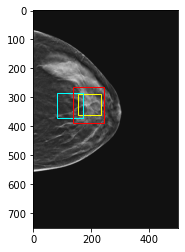

In [21]:
# [STAR] Code to compare the ground truth and predicted mask

import matplotlib.patches as patches

index        = random.randint(0, len(valid_dataset)-1)
images, b, c = valid_dataset[index]

print('Ground Truth ', b['boxes'].data.cpu().numpy())

plt.imshow(images[0], cmap='gray')
ax   = plt.gca()

if(len(all_target1[index]) > 0):
    print(all_target1[index])
    print(all_scores1[index])
    
    temp  = all_target1[index]
    index = 0
    rect  = patches.Rectangle((temp[index][0], temp[index][1]), temp[index][2]-temp[index][0], temp[index][3]-temp[index][1], linewidth=1, edgecolor='yellow', fill = False)
    ax.add_patch(rect)
else:
    print('Not found 1')

if(len(all_target[index]) > 0):
    print(all_target[index])
    print(all_scores[index])
    
    temp  = all_target[index]
    index = 0
    rect  = patches.Rectangle((temp[index][0], temp[index][1]), temp[index][2]-temp[index][0], temp[index][3]-temp[index][1], linewidth=1, edgecolor='cyan', fill = False)
    ax.add_patch(rect)
else:
    print('Not found 2')

temp  = b['boxes'].data.cpu().numpy()#all_target[index]
index = 0
rect  = patches.Rectangle((temp[index][0], temp[index][1]), temp[index][2]-temp[index][0], temp[index][3]-temp[index][1], linewidth=1, edgecolor='red', fill = False)
ax.add_patch(rect)


#rect = patches.Rectangle((0, 0), 500, 100, linewidth=2, edgecolor='cyan', fill = False)

plt.show()


In [ ]:
# [STAR] For doing the inference on the test images

model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

In [91]:
# Some code to do visualization


BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

fp    = "/home/yu-hao/Downloads/coco_sample.png"
image = cv2.imread(fp)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)

    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img


def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

(375, 500, 3)


In [ ]:
# [STAR] Plot image 1

import matplotlib.patches as patches

#train_dataset1     = DBTDataset(train_set=1)
#index = random.randint(0, len(train_dataset)-1)
#image, b, c = train_dataset[index]

case_index       = random.randint(0, len(train_dataset)-1)
image, b, c = train_dataset[case_index]
image       = np.moveaxis(image, 0, -1)

# transform = A.Compose(
#     [A.HorizontalFlip(p=0.95)],
#     bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
# )

# temp_box = b['boxes'].data.cpu().numpy()

# temp_box[0][0] = temp_box[0][0]
# temp_box[0][2] = temp_box[0][2]
# temp_box[0][3] = temp_box[0][3]
# temp_box[0][1] = temp_box[0][1]

# random.seed(7)
# transformed = transform(image=image, bboxes=temp_box, labels=b['labels'])

plt.imshow(image)
ax   = plt.gca()

temp  = b['boxes']#b[index]
index = 0
rect  = patches.Rectangle((temp[index][0], temp[index][1]), temp[index][2]-temp[index][0], temp[index][3]-temp[index][1], linewidth=1, edgecolor='cyan', fill = False)
ax.add_patch(rect)

In [ ]:
# [STAR] Some code to test the augmentation

import matplotlib.patches as patches

#case_index  = random.randint(0, len(valid_dataset)-1)
image, b, c = valid_dataset[case_index]
image       = np.moveaxis(image, 0, -1)

transform = A.Compose(
    #[A.HorizontalFlip(p=0.99)],
    [A.VerticalFlip(p=0.99)],
    bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),
)

temp_box       = b['boxes'].data.cpu().numpy()

temp_box[0][0] = temp_box[0][0]
temp_box[0][2] = temp_box[0][2]
temp_box[0][3] = temp_box[0][3]
temp_box[0][1] = temp_box[0][1]
temp           = temp_box

if(0):
    transformed = transform(image=image, bboxes=temp_box, labels=b['labels'])
    image    = transformed['image']
    temp     = transformed['bboxes']

plt.imshow(image)
ax    = plt.gca()
index = 0
rect  = patches.Rectangle((temp[index][0], temp[index][1]), temp[index][2]-temp[index][0], temp[index][3]-temp[index][1], linewidth=1, edgecolor='cyan', fill = False)
ax.add_patch(rect)

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

images, targets, image_ids = next(iter(train_data_loader))
images  = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes  = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()

In [ ]:
# [STAR] For plotting the images

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [138]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = DBTDataset()
#valid_dataset = DBTDataset()


# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=collate_fn
)

# valid_data_loader = DataLoader(
#     valid_dataset,
#     batch_size=8,
#     shuffle=False,
#     num_workers=4,
#     collate_fn=collate_fn
# )

In [143]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

num_classes = 2

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.00001, momentum=0.9, weight_decay=0.5)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None

num_epochs = 20

In [145]:
num_epochs = 2000

loss_hist = Averager()
itr = 1
#train_dataset = td1
#model.train()
for epoch in range(num_epochs):
    loss_hist.reset()
    
    for k in range(len(train_dataset)-1):
        images, targets, image_ids = train_dataset[k]
        #for images, targets, image_ids in train_data_loader:
        #print(images, targets)
        
        images  = [images]
        targets = [targets]
        #images  = list(image.to(device) for image in images)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        
        loss_dict = model(images, targets)
        
        #losses = loss_dict['loss_rpn_box_reg'] + loss_dict['loss_objectness']
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(loss_dict)
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}") 

{'loss_classifier': tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(nan, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.7729, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0035, device='cuda:0', grad_fn=<DivBackward0>)}
Iteration #50 loss: nan
{'loss_classifier': tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(nan, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.7726, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0048, device='cuda:0', grad_fn=<DivBackward0>)}
Iteration #100 loss: nan
{'loss_classifier': tensor(nan, device='cuda:0', grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(nan, device='cuda:0', grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.7703, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0031, device='cuda:0', grad

KeyboardInterrupt: 

In [121]:
print(targets)

[{'boxes': tensor([[  76., 1665.,  254., 1791.]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'image_id': tensor([156]), 'area': tensor([22428.], device='cuda:0'), 'iscrowd': tensor([0], device='cuda:0')}]


In [107]:
model.eval()

images, targets, image_ids = train_dataset[k]
images  = [images]
targets = [targets]

loss_dict = model(images)
        

In [106]:
model.eval()
images  = [images]
#cpu_device = torch.device("cpu")
outputs = model(images)
#outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

AttributeError: 'list' object has no attribute 'shape'

In [110]:
print(loss_dict[0]['boxes'])

tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward>)


In [101]:
print(images[0].shape)

torch.Size([1, 3000, 2000])


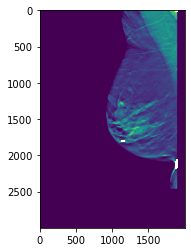

In [103]:
plt.imshow(images[0][0].cpu())